Let's first look at the filaments found by Suri et al. (2019) in the CARMA-NRO Orion C18O data. Let's load the filament (x,y,v) coordinates into tables. From Sumeyye's readme:


> Each identified filament has its own txt file that is organized as (x y v) coordinates of the pixels along the corresponding filament.
>
>Two points I should mention: 
>1. Because the c18o cube was too large, I divided it into two parts in order to be able to identify the filaments – >hence the folders containing northern and southern filaments. The northern and southern c18o cubes are also attached. >These will help you convert the identified filament pixel coordinates (using, for example, astropy wcs) to the pixel >coordinates of whichever map you are using. 
>
>2. Some txt files may be empty or have something like 2 or 5 pixels. You can eliminate these by setting up a threshold >when you read the file, saying if it has less than 15 pixels (roughly 3 beam sizes), ignore the filament.

So, the first thing I'll do is get the WCS information from the southern and northern C18O cubes that Sumeyye used. I wrote out the headers of the two files so I could get rid of the actual cubes if I don't need them.

In [332]:
import warnings
warnings.filterwarnings('ignore')
from astropy.wcs import WCS
from spectral_cube import SpectralCube
import matplotlib.pyplot as plt

c18_north = SpectralCube.read("../filaments/c18o_north.fits")
c18_south = SpectralCube.read("../filaments/c18o_south.fits")

c18_north.header

print(WCS("../filaments/c18o_north_hdr.txt"))
print(WCS("../filaments/c18o_south_hdr.txt"))

WCS Keywords

Number of WCS axes: 3
CTYPE : 'RA---SIN'  'DEC--SIN'  'VRAD'  
CRVAL : 83.8742052144  -5.81309140504  259.95804083  
CRPIX : 329.0  -15.0  -19.5  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : -0.000555555576728  0.000555555576728  220.028195867  
NAXIS : 1110  1723  39
WCS Keywords

Number of WCS axes: 3
CTYPE : 'RA---SIN'  'DEC--SIN'  'VRAD'  
CRVAL : 83.8742052144  -5.81309140504  259.95804083  
CRPIX : 1018.0  1814.0  -19.5  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : -0.000555555576728  0.000555555576728  220.028195867  
NAXIS : 1799  1835  30


Now I'll read in the filament coordinate files and plot them.

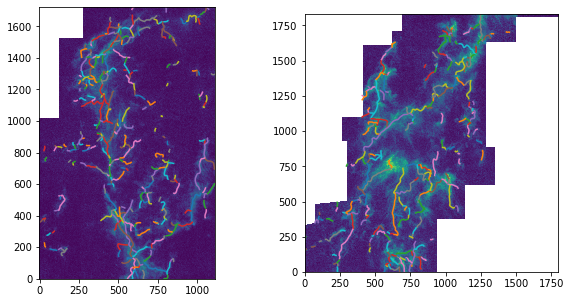

In [121]:
from glob import glob
from astropy.io import ascii
import astropy.units as u
import numpy as np
# fig = plt.figure(figsize=(8,8))

fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].imshow(c18_north.max(axis=0).data, origin='lower')

ax[1].imshow(c18_south.max(axis=0).data, origin='lower')

fil_dir = "../filaments/filaments_north/"
files = glob(fil_dir+"filament*.txt")
for file in files:
#     print(file)
    t = ascii.read(file, names=['x','y','v'])
    x,y,v = t['x'].data, t['y'].data, t['v'].data
    ra,dec,vel = wcs_north.all_pix2world(np.array([x,y,v]).T, 1).T
    ra,dec,vel = ra*u.deg, dec*u.deg, vel*u.m/u.s
    
#     print(w)
#     print(ra,dec,vel)
    if len(x) >= 15: 
        ax[0].plot(x,y)
#     print(type(x))

fil_dir = "../filaments/filaments_south/"
files = glob(fil_dir+"filament*.txt")
for file in files:
#     print(file)
    t = ascii.read(file, names=['x','y','v'])
    x,y,v = t['x'].data, t['y'].data, t['v'].data
    ra,dec,vel = wcs_north.all_pix2world(np.array([x,y,v]).T, 1).T
    ra,dec,vel = ra*u.deg, dec*u.deg, vel*u.m/u.s
    
#     print(w)
#     print(ra,dec,vel)
    if len(x) >= 15: 
        ax[1].plot(x,y)
#     print(type(x))

Now, let's use the astropy.wcs method all_pix2world to convert the pixel coordinates of the filaments to RA/DEC/Velocity coordinates. I'm not sure whether the origin should be 0-indexed or 1-indexed. But this one pixel shift will probably be insignificant regardless. Test the conversion by converting back to pixel coordinates to display the filaments on the full c18o cube.

In [139]:
c18_full = SpectralCube.read("../cubes/mask_imfit_c18o_pix_2_Tmb.fits")
c18_full.allow_huge_operations = True
wcs_full = WCS(c18_full.header)
c18_full_peak = c18_full.max(axis=0)

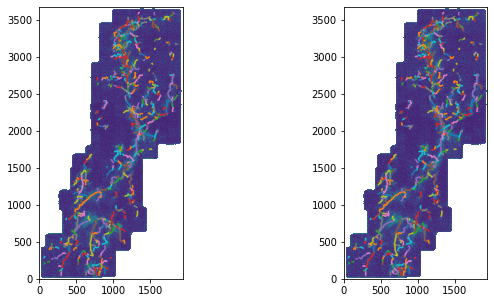

In [149]:
fig, axarr = plt.subplots(1,2, figsize=(10,5))
axarr[0].imshow(c18_full_peak.data, origin='lower')
axarr[1].imshow(c18_full_peak.data, origin='lower')

north_dir = "../filaments/filaments_north/"
south_dir = "../filaments/filaments_south/"

files = glob("../filaments/filaments_*/filament*.txt")
for d, wcs in zip([north_dir, south_dir], [wcs_north, wcs_south]):
    files = glob(d + "filament*.txt")
    
    for file in files:
        t = ascii.read(file, names=['x','y','v'])
        x,y,v = t['x'].data, t['y'].data, t['v'].data
        
        ra0,dec0,vel0 = wcs.all_pix2world(np.array([x,y,v]).T, 0).T
        ra0,dec0,vel0 = ra0*u.deg, dec0*u.deg, vel0*u.m/u.s
        x_full0, y_full0, v_full0 = wcs_full.all_world2pix(np.array([ra0,dec0,vel0]).T, 0).T
        
        ra1,dec1,vel1 = wcs.all_pix2world(np.array([x,y,v]).T, 1).T
        ra1,dec1,vel1 = ra1*u.deg, dec1*u.deg, vel1*u.m/u.s
        x_full1, y_full1, v_full1 = wcs_full.all_world2pix(np.array([ra1,dec1,vel1]).T, 1).T
    
#     print(w)
#     print(ra,dec,vel)
        if len(x_full0) >= 15: 
            axarr[0].plot(x_full0,y_full0)
            axarr[1].plot(x_full1,y_full1)
plt.savefig("c18o_filament_origincomp.pdf")
    # print(files)

I'll assume 0-indexing was used to record the x,y,v coordinates of each filament. It will be easier for me to work with the filaments if they are saved in RA/DEC/Velocity coordinates, so I'll write out each filament like this.

In [333]:
north_dir = "../filaments/filaments_north/"
south_dir = "../filaments/filaments_south/"

files = glob("../filaments/filaments_*/filament*.txt")

for d, wcs in zip([north_dir, south_dir], [wcs_north, wcs_south]):
    files = glob(d + "filament*.txt")
    
    for file in files:
        t = ascii.read(file, names=['x','y','v'])
        x,y,v = t['x'].data, t['y'].data, t['v'].data
        
#         print(wcs.all_pix2world(np.array([x,y,v]).T,0).shape)
        ascii.write(wcs.all_pix2world(np.array([x,y,v]).T,0), d[:-1]+"_wcs/"+file.split('/')[-1], names=["RAJ2000", "DEJ2000", "VEL"])
        
#         ra,dec,vel = ra*u.deg, dec*u.deg, vel*u.m/u.s
#         x_full, y_full, v_full = wcs_full.all_world2pix(np.array([ra,dec,vel]).T, 0).T
    
#     print(w)
#     print(ra,dec,vel)
# plt.savefig("c18o_filament_origincomp.pdf")


FileNotFoundError: [Errno 2] No such file or directory: '../filaments/filaments_north_wcs/filament359.txt'

Now that we have the filaments in WCS coordinates, we can use the RA and DEC of the outflow sources to find the closest filament to each source. Maybe we could also use the C18O fit velocity vsys to find the outflow that's also closest in velocity. But since we don't really know which component an outflow source should necessarily be assigned to, in cases where there are strongly overlapping filaments this isn't really breaking the degeneracy. But let's see if there are cases of this for the outflow sources. 

In [334]:
# outflow_table = ascii.read("physics_outflows.txt")
# files = glob("../filaments/filaments_wcs/*.txt")
# l_min_dist = []
# l_fil_min_dist = []
# l_source = []
# l_fils_within_10arcmin = []
# for outflow in outflow_table:
#     if outflow["Source"] in l_source:
#         continue
# #     if outflow["Source"] != 'davis 11':
# #         continue
#     min_dist = np.inf
#     fil_min_dist = None
#     fils_within_10arcmin = []
#     for file in files:
#         filament = ascii.read(file)
#         if len(filament["RAJ2000"]) < 15:
#             continue
#         dist = ((outflow["RAJ2000"] - filament["RAJ2000"])**2. + (outflow["DEJ2000"] - filament["DEJ2000"])**2.)**0.5
        
#         if min(dist) < min_dist:
#             min_dist = min(dist)
#             fil_min_dist = file.split('/')[-1].split('.')[0].strip("filament")
#         if min(dist) <= (1./6.):
#             fils_within_10arcmin.append(file.split('/')[-1].split('.')[0].strip("filament"))
    
#     #Save the filament which is closest to the outflow and the minimum distance from the source to that filament.
#     print("The closest filament to {} is {} with a minimum distance of {:.2g} degrees".format(
#         outflow["Source"], fil_min_dist, min_dist))
#     l_source.append(outflow["Source"])
#     l_min_dist.append(min_dist)
#     l_fil_min_dist.append(fil_min_dist)
#     l_fils_within_10arcmin.append(" ".join(fils_within_10arcmin))
# ascii.write([l_source, l_fil_min_dist, l_min_dist, l_fils_within_10arcmin],
#             "closest_filament.txt",
#             names=["source", "filament", "dist_min", "within_10arcmin"])
# #     print(outflow_table["DEJ2000"])

KeyboardInterrupt: 

Let's plot the projected filaments on an outflow stamp.

[43]
{'amplitude': 50.332855, 'mean': 8.814063863832775, 'stddev': 0.5780703674328549}
[[ 3.19124962e+00 -4.88733248e-18 -8.53917436e-02]
 [-4.88733248e-18  6.85475980e-03 -7.60121166e-19]
 [-8.53917436e-02 -7.60121166e-19  6.85475980e-03]]


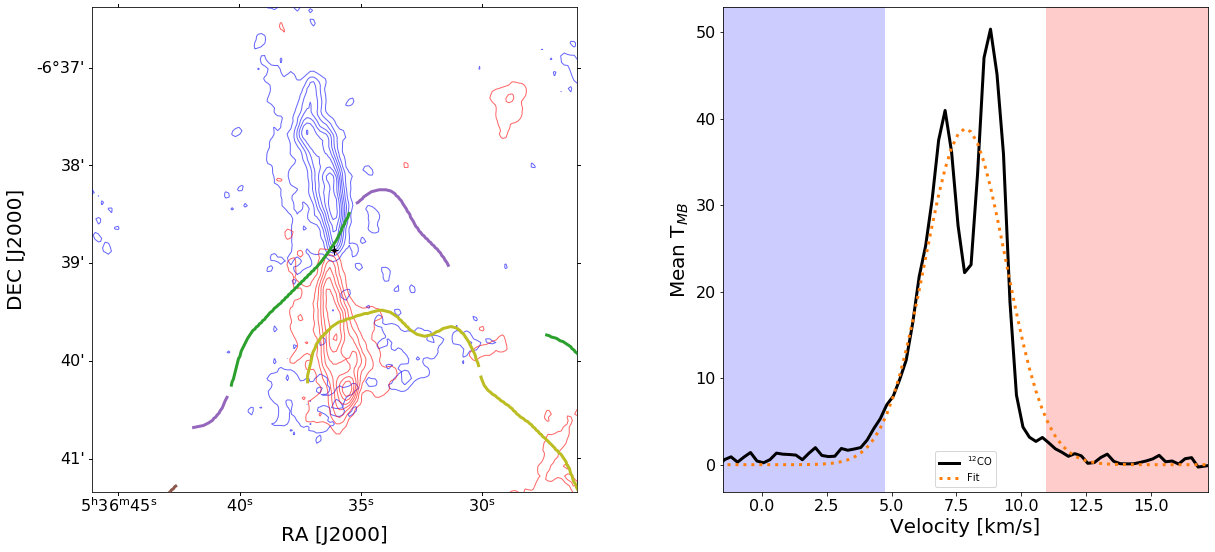

In [779]:
from astropy.coordinates import SkyCoord
from stamp import plot_finder
from astroquery.simbad import Simbad
import astropy.units as u
import matplotlib
source = "hops 169"
# coord = 
c12 = "../cubes/mask_imfit_12co_pix_2_Tmb.fits"
coord = SkyCoord(
    outflow_table[outflow_table["Source"] == source]["RAJ2000"][0],
    outflow_table[outflow_table["Source"] == source]["DEJ2000"][0], unit=u.deg)
matplotlib.style.use("presentation")
do_fit = 1
nsigma_vel = 2.
# blue_vel = 4.7*u.km/u.s
# red_vel = 10.*u.km/u.s
fit_radius = 15*u.arcsec
width = height = 5*u.arcmin
start = 5.
stop = 50.
step = 5.
fig = plt.figure(figsize=(20,10))
plot_finder(c12, coord=coord,
            fit_cube=c12, fit_radius=fit_radius,
            nsigma_vel=nsigma_vel, blue_vel=blue_vel, red_vel=red_vel,
            fit_spectrum=do_fit, channel_sigma=0.8*u.K,
            region_width=width, region_height=height,
            blue_levels=np.arange(start, stop+step, step), red_levels=np.arange(start, stop+step, step),
            show_stamp=True, show_catalogs=True, show_spectrum=True, show_fit=do_fit,
            show_fitcircle=False, show_vrange=True, interactive=False, show_name=False,
            show_contour=1, show_redblue=False, show_outflows=False, redblue_mode='subtract',
            imshow_kwargs={"cmap":"RdBu_r", "interpolation":"none"},
            blue_contour_kwargs={'colors':'blue', 'linewidths':1, 'alpha':0.6, 'zorder':3},
            red_contour_kwargs={'colors':'red', 'linewidths':1, 'alpha':0.6, 'zorder':3},
            fig=fig, savefig=False, verbose=False, autoguess=True,
            spec_label=r'$^{12}$CO'
            )

ax = fig.axes[0]


t_fil = ascii.read("closest_filament.txt")
row = t_fil[t_fil["source"] == source]
close_fils = row["within_10arcmin"][0].split()
for fil in close_fils:
    fil_file = "../filaments/filaments_wcs/{}.txt".format(fil)
    fil_coords = ascii.read(fil_file)
    ax.plot(fil_coords["RAJ2000"], fil_coords["DEJ2000"], '-',
            transform=ax.get_transform('world'), zorder=3)
plt.savefig("test.pdf")
plt.show()

We want to find the closest position on a filament to the source. After some Googling, the python package Shapely looks like a promising tool to do this. Looking at the documentation, we'll use the project and interpolate methods.

In [341]:
import shapely.geometry as geom
import numpy as np
t_fil = ascii.read("closest_filament.txt")
source = "hops 169"
closest_fil = t_fil[t_fil["source"] == source]["filament"][0]
fil_file =  "../filaments/filaments_wcs/filament{}.txt".format(closest_fil)
fil_coords = ascii.read(fil_file)["RAJ2000", "DEJ2000"]
print(fil_coords)
# nearest_fil = 
line = geom.LineString(fil_coords)
coord = SkyCoord.from_name(source)
point = geom.Point(coord.ra.value, coord.dec.value)
closest_point = line.interpolate(line.project(point))
closest_point.x, closest_point.y


     RAJ2000            DEJ2000      
----------------- -------------------
84.16808498127106  -6.670825434426641
 84.1679727781897  -6.670269874436011
84.16774877231391  -6.669825495697348
84.16763663644169  -6.669381059291879
84.16752450079167  -6.668936622915845
84.16741236536386 -6.6684921865692575
84.16730023015822  -6.668047750252027
84.16718809517472  -6.667603313964162
84.16707596041337  -6.667158877705638
84.16696382587413  -6.666714441476443
              ...                 ...
84.14961211936622  -6.645276328098482
84.14938814283322  -6.644831944994952
84.14916416672568 -6.6443875618533275
 84.1490520546468  -6.643943124694579
  84.148828141324  -6.643609864293582
84.14860422831806  -6.643276603832658
84.14849211704484 -6.6428321666885735
84.14826820464839   -6.64249890616102
84.14804429256871   -6.64216564557349
84.14793218210092  -6.641721208443911
84.14784817663937  -6.641526784007522
Length = 83 rows


(84.15114242121747, -6.647757523176592)

In [342]:
# plt.plot(fil_coords["RAJ2000"], fil_coords["DEJ2000"], '.')
# plt.ylim(-6.66, -6.65)

x, y = fil_coords["RAJ2000"], fil_coords["DEJ2000"]

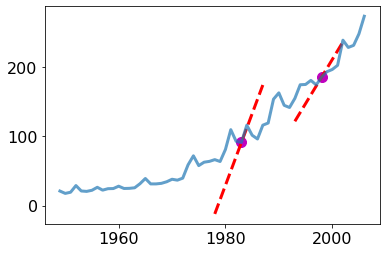

In [357]:
from scipy import interpolate
from numpy import arange
# Fresh potatoes: Annual Consumer price index, 1949-2006
# obatined at https://explore.data.gov/Agriculture/U-S-Potato-Statistics/cgk7-6ccj
price_index = [21.0,17.6,19.3,28.9,21.1,20.5,22.1,26.4,22.3,24.4,24.6,28.0,24.7,24.9,25.7,31.6,39.1,31.3,31.3,32.1,34.4,38.0,36.7,39.6,58.8,71.8,57.7,62.6,63.8,66.3,63.6,81.0,109.5,92.7,91.3,116.0,101.5,96.1,116.0,119.1,153.5,162.6,144.6,141.5,154.6,174.3,174.7,180.6,174.1,185.2,193.1,196.3,202.3,238.6,228.1,231.1,247.7,273.1]
t = np.arange(1949,2007)

def draw_tangent(x,y,a):
 # interpolate the data with a spline
 spl = interpolate.splrep(x,y)
 small_t = np.arange(a-5,a+5)
 fa = interpolate.splev(a,spl,der=0)     # f(a)
 fprime = interpolate.splev(a,spl,der=1) # f'(a)
 tan = fa+fprime*(small_t-a) # tangent
 plt.plot(a,fa,'om',small_t,tan,'--r')

draw_tangent(t,price_index,1983)
draw_tangent(t,price_index,1998)

plt.plot(t,price_index,alpha=0.7)
plt.show()

211
(211,) (211,)


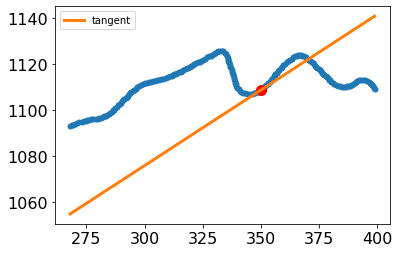

In [410]:
from scipy import interpolate
import matplotlib.pyplot as plt
import numpy as np
x,y,v = np.loadtxt("../filaments/filaments_north/filament14.txt").T

tck = interpolate.splrep(x,y)
# print(tck)

x0 = 350
y0 = interpolate.splev(x0,tck)
dydx = interpolate.splev(x0,tck,der=1)

tngnt = lambda x: dydx*x + (y0-dydx*x0)

plt.plot(x,y, '.')
plt.plot(x0,y0, "or")
plt.plot(x,tngnt(x), label="tangent")

plt.legend()
plt.show()
# interpolate.splrep?

I'm having trouble using the spline interpolation in RA/DEC coordinates. The scipy functions must not like how close the RA/DEC of two adjacent points on a filament are. So I think I should work in pixel coordinates to compute the tangent. Thus, I'll write out all the filaments in the pixel coordinates of the full c18o map.

In [ ]:
north_dir = "../filaments/filaments_north/"
# south_dir = "../filaments/filaments_south/"

# files = glob("../filaments/filaments_*/filament*.txt")
# wcs_full = WCS(c18_full.header)
# outdir = "../filaments/filaments_fullmap/"

# for d, wcs, sub in zip([north_dir, south_dir], [wcs_north, wcs_south], ["north", "south"]):
#     files = glob(d + "filament*.txt")
    
#     for file in files:
#         t = ascii.read(file, names=['x','y','v'])
#         x,y,v = t['x'].data, t['y'].data, t['v'].data
        
#         world = wcs.all_pix2world(np.array([x,y,v]).T,0)
# #         print(file)
#         pix_full = wcs_full.all_world2pix(world,0)
#         fil_name = file.split('/')[-1].split('.')[0]
#         np.savetxt("{}{}_{}.txt".format(outdir, fil_name, sub), pix_full)
        
#         ascii.write(
#             wcs.all_pix2world(np.array([x,y,v]).T,0), d[:-1]+"_fullmap/"+file.split('/')[-1].split('.')[0]+"_")
        
#         ra,dec,vel = ra*u.deg, dec*u.deg, vel*u.m/u.s
#         x_full, y_full, v_full = wcs_full.all_world2pix(np.array([ra,dec,vel]).T, 0).T
    
#     print(w)
#     print(ra,dec,vel)
# plt.savefig("c18o_filament_origincomp.pdf")




Use spline interpolation to compute the filament position angle.

<SkyCoord (ICRS): (ra, dec) in deg
    (83.847083, -5.119444)> (array(1127.61432566), array(3111.52421279))
Error on input data
Filament 90_north has non-unique x values, flipping the x and y coordinates to use spline interpolation.
Smoothing parameter s: 1.653350191425223
X-coordinate of closest position: 3126.1999999999753
Slope of tangent: 0.5354942203506058
Position Angle of Tangent: 118.16879207458663 E of N


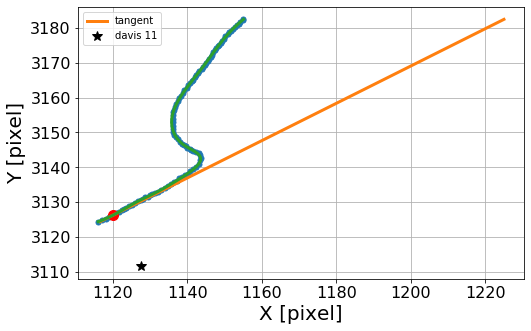

<SkyCoord (ICRS): (ra, dec) in deg
    (83.8625, -5.165)> (array(1099.97293371), array(3029.52998576))
Smoothing parameter s: 0.25872576032110767
X-coordinate of closest position: 1098.7499999999952
Slope of tangent: -0.32893719606401667
Position Angle of Tangent: 71.79204145572751 E of N


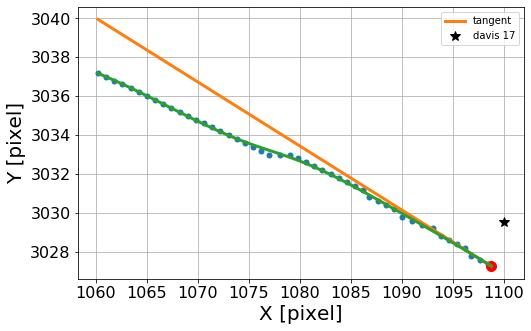

<SkyCoord (ICRS): (ra, dec) in deg
    (83.862083, -5.185278)> (array(1100.71979167), array(2993.03183414))
Smoothing parameter s: 0.4073841588636049
X-coordinate of closest position: 1103.2000000000114
Slope of tangent: 1.060952900673583
Position Angle of Tangent: 136.69403495574676 E of N


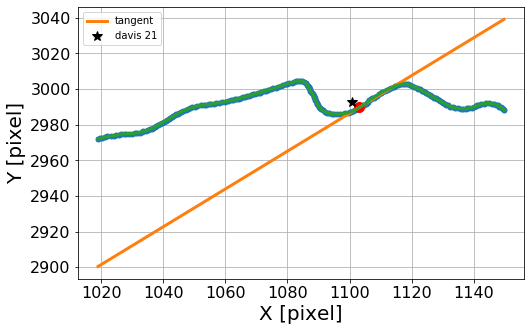

<SkyCoord (ICRS): (ra, dec) in deg
    (83.82625, -5.528333)> (array(1164.90701496), array(2375.54995578))
Error on input data
Filament 50_north has non-unique x values, flipping the x and y coordinates to use spline interpolation.
Smoothing parameter s: 2.7558882062293777
X-coordinate of closest position: 2395.800000000037
Slope of tangent: -0.6890571526688908
Position Angle of Tangent: 55.4309378111447 E of N


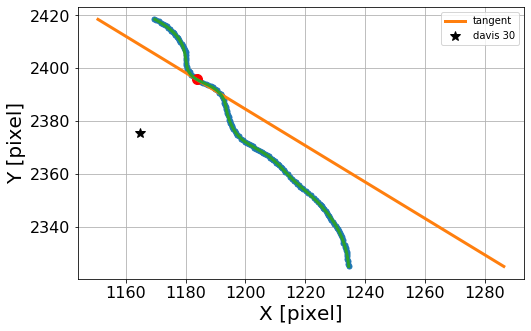

<SkyCoord (ICRS): (ra, dec) in deg
    (84.047917, -6.372778)> (array(768.2406446), array(855.52305002))
Error on input data
Filament 18_south has non-unique x values, flipping the x and y coordinates to use spline interpolation.
Flipping x and y still didn't help! Unflipping and only interpolating 20 points on either            side of the minimum distance point.
This also didn't work! Last resort: sorting by x-value.
Smoothing parameter s: 4.821719839076053
X-coordinate of closest position: 786.7500000000082
Slope of tangent: -1.2931796600353256
Position Angle of Tangent: 37.71434226597559 E of N


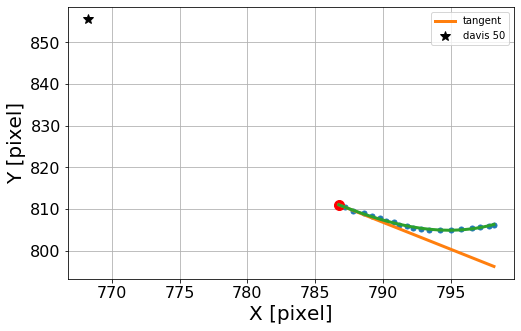

<SkyCoord (ICRS): (ra, dec) in deg
    (83.7875, -5.9743)> (array(1234.21085181), array(1572.80362996))
Smoothing parameter s: 0.08308306669460155
X-coordinate of closest position: 1234.0000000000057
Slope of tangent: 0.005919903791481034
Position Angle of Tangent: 90.3391815401772 E of N


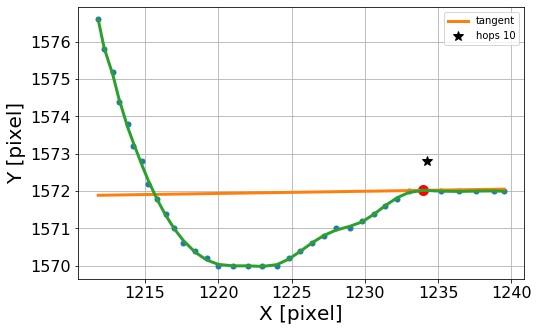

<SkyCoord (ICRS): (ra, dec) in deg
    (83.8059, -5.9661)> (array(1201.27259783), array(1587.56808471))
Smoothing parameter s: 1.305414174325704
X-coordinate of closest position: 1206.0000000000202
Slope of tangent: 0.3566469410426717
Position Angle of Tangent: 109.62862044325337 E of N


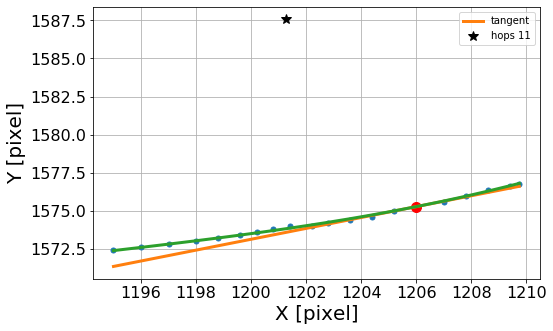

<SkyCoord (ICRS): (ra, dec) in deg
    (83.7858, -5.9317)> (array(1237.26649397), array(1649.48292485))
Smoothing parameter s: 0.7885314907038445
X-coordinate of closest position: 1231.7999999999984
Slope of tangent: -1.105802029971942
Position Angle of Tangent: 42.12370085617473 E of N


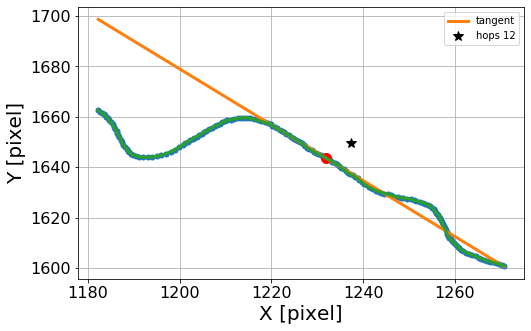

<SkyCoord (ICRS): (ra, dec) in deg
    (83.7941, -5.5851)> (array(1222.49397765), array(2273.36387173))
Error on input data
Filament 103_north has non-unique x values, flipping the x and y coordinates to use spline interpolation.
Flipping x and y still didn't help! Unflipping and only interpolating 20 points on either            side of the minimum distance point.
Smoothing parameter s: 0.32701565644673175
X-coordinate of closest position: 1225.200000000009
Slope of tangent: -0.9733520698864332
Position Angle of Tangent: 45.77366890293147 E of N


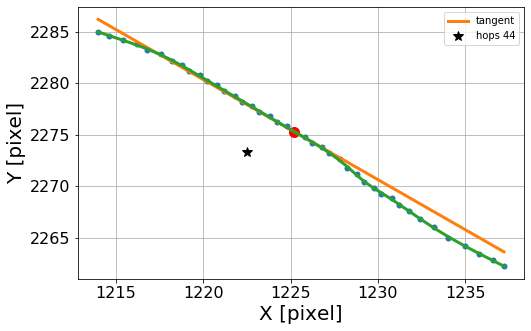

<SkyCoord (ICRS): (ra, dec) in deg
    (83.6704, -5.529)> (array(1444.13099839), array(2374.28725511))
Error on input data
Filament 241_north has non-unique x values, flipping the x and y coordinates to use spline interpolation.
Smoothing parameter s: 0.11669073925639467
X-coordinate of closest position: 2374.0000000000227
Slope of tangent: -104.97229051491033
Position Angle of Tangent: 0.5458016216759916 E of N


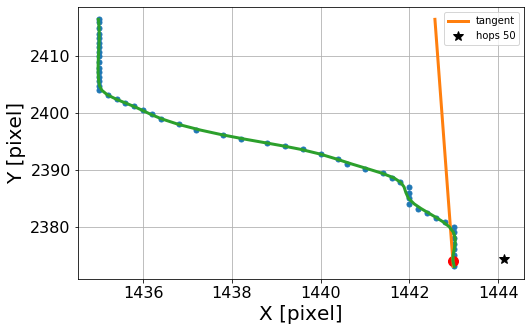

<SkyCoord (ICRS): (ra, dec) in deg
    (83.8311, -5.2591)> (array(1156.25186423), array(2860.15660768))
Smoothing parameter s: 1.2002548676329754
X-coordinate of closest position: 1158.1999999999953
Slope of tangent: -0.0829383368239613
Position Angle of Tangent: 85.25883459553893 E of N


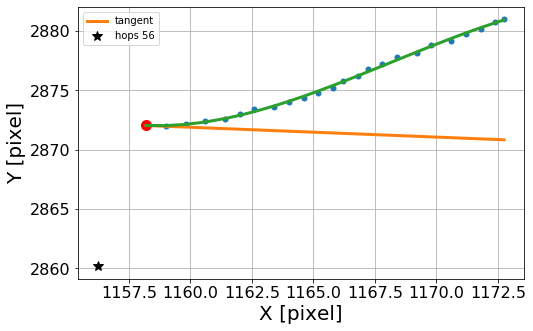

<SkyCoord (ICRS): (ra, dec) in deg
    (83.8271, -5.2273)> (array(1163.42584926), array(2917.39320201))
Error on input data
Filament 61_north has non-unique x values, flipping the x and y coordinates to use spline interpolation.
Smoothing parameter s: 1.4479822867871501
X-coordinate of closest position: 2913.599999999981
Slope of tangent: 3.190025135124462
Position Angle of Tangent: 162.59498380357468 E of N


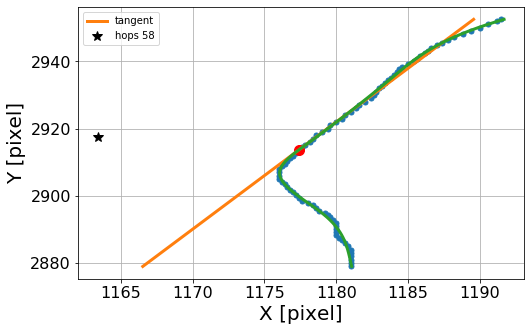

<SkyCoord (ICRS): (ra, dec) in deg
    (83.8339, -5.221)> (array(1151.23748382), array(2928.73354341))
Error on input data
Filament 30_north has non-unique x values, flipping the x and y coordinates to use spline interpolation.
Smoothing parameter s: 1.3516776145634148
X-coordinate of closest position: 2926.0000000000155
Slope of tangent: -4.806382889579901
Position Angle of Tangent: 11.753095623582794 E of N


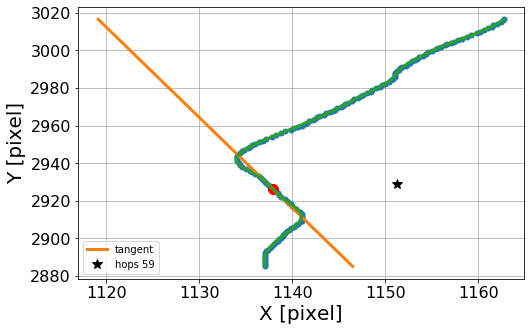

<SkyCoord (ICRS): (ra, dec) in deg
    (83.8472, -5.2009)> (array(1127.3983597), array(2964.91296069))
Error on input data
Filament 30_north has non-unique x values, flipping the x and y coordinates to use spline interpolation.
Smoothing parameter s: 1.4208928905548392
X-coordinate of closest position: 2957.000000000009
Slope of tangent: 2.024257819154296
Position Angle of Tangent: 153.7102495372828 E of N


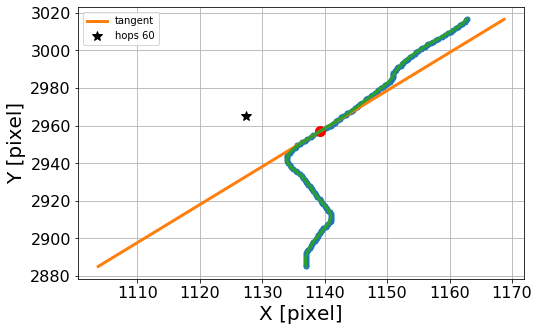

<SkyCoord (ICRS): (ra, dec) in deg
    (83.8513, -5.1418)> (array(1120.05257074), array(3071.28660302))
Error on input data
Filament 154_north has non-unique x values, flipping the x and y coordinates to use spline interpolation.
Smoothing parameter s: 1.4350291554540013
X-coordinate of closest position: 3071.0000000000036
Slope of tangent: -23.279619932743486
Position Angle of Tangent: 2.4596869507112444 E of N


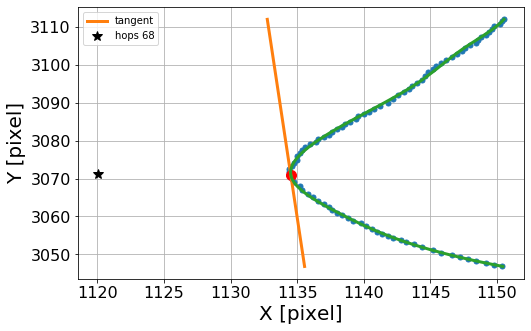

<SkyCoord (ICRS): (ra, dec) in deg
    (83.8434, -5.1347)> (array(1134.21596117), array(3084.06504465))
Error on input data
Filament 154_north has non-unique x values, flipping the x and y coordinates to use spline interpolation.
Smoothing parameter s: 0.3771484119298282
X-coordinate of closest position: 3082.400000000014
Slope of tangent: 2.0030923613160287
Position Angle of Tangent: 153.47034089081794 E of N


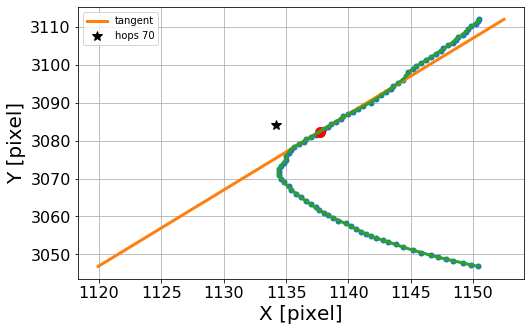

<SkyCoord (ICRS): (ra, dec) in deg
    (83.8567, -5.1326)> (array(1110.37213747), array(3087.84579531))
Error on input data
Filament 154_north has non-unique x values, flipping the x and y coordinates to use spline interpolation.
Smoothing parameter s: 2.693822742338955
X-coordinate of closest position: 3078.399999999998
Slope of tangent: 2.9011589213318745
Position Angle of Tangent: 160.9814479043414 E of N


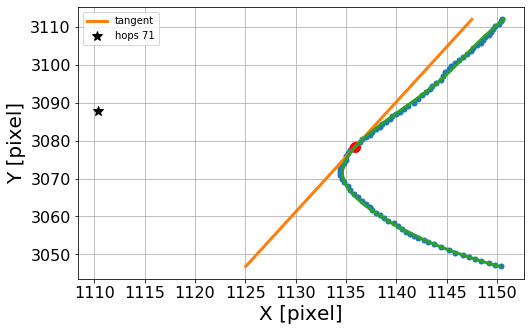

<SkyCoord (ICRS): (ra, dec) in deg
    (83.8611, -5.1029)> (array(1102.48498203), array(3141.30206882))
Smoothing parameter s: 0.08492782068253579
X-coordinate of closest position: 1101.6000000000067
Slope of tangent: -4.729120964505793
Position Angle of Tangent: 11.93964315447026 E of N


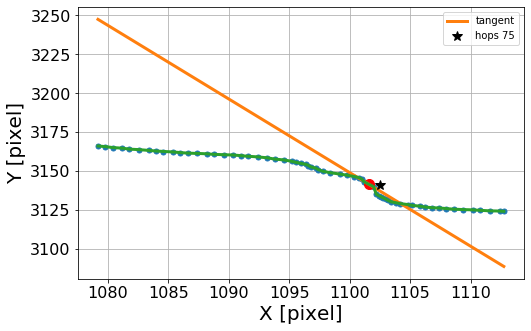

<SkyCoord (ICRS): (ra, dec) in deg
    (83.8576, -5.0955)> (array(1108.76035419), array(3154.62087001))
Smoothing parameter s: 1.1507776110759942
X-coordinate of closest position: 1099.800000000008
Slope of tangent: -1.3729027491403833
Position Angle of Tangent: 36.06898500818726 E of N


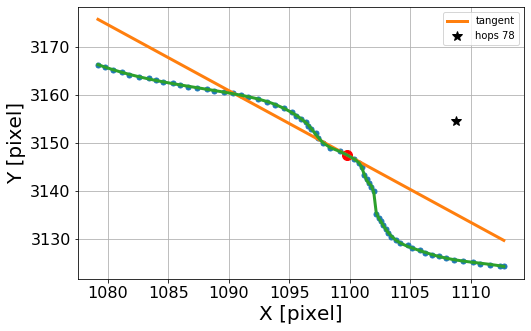

<SkyCoord (ICRS): (ra, dec) in deg
    (83.8665, -5.0828)> (array(1092.80393675), array(3177.4793862))
Smoothing parameter s: 1.6798993054379747
X-coordinate of closest position: 1085.3999999999953
Slope of tangent: -0.45495455435439264
Position Angle of Tangent: 65.53662216718735 E of N


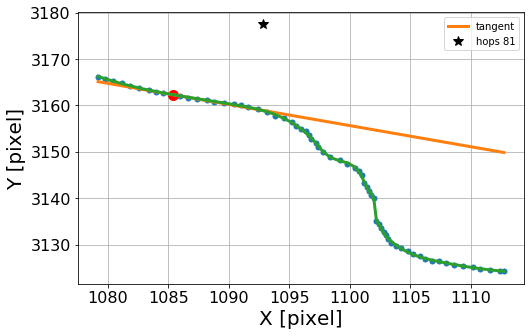

<SkyCoord (ICRS): (ra, dec) in deg
    (83.8607, -5.0653)> (array(1103.2035377), array(3208.97657024))
Error on input data
Filament 162_north has non-unique x values, flipping the x and y coordinates to use spline interpolation.
Smoothing parameter s: 1.3880964192007132
X-coordinate of closest position: 3218.600000000026
Slope of tangent: 1.0379514339774008
Position Angle of Tangent: 136.0668584384237 E of N


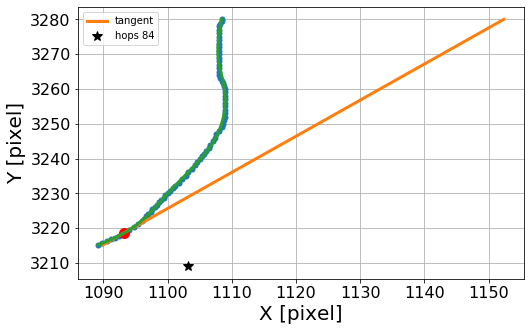

<SkyCoord (ICRS): (ra, dec) in deg
    (83.8478, -5.0246)> (array(1126.33581907), array(3282.22916787))
Smoothing parameter s: 0.1938452610934395
X-coordinate of closest position: 1125.2000000000007
Slope of tangent: 0.30803290096578007
Position Angle of Tangent: 107.12055407362442 E of N


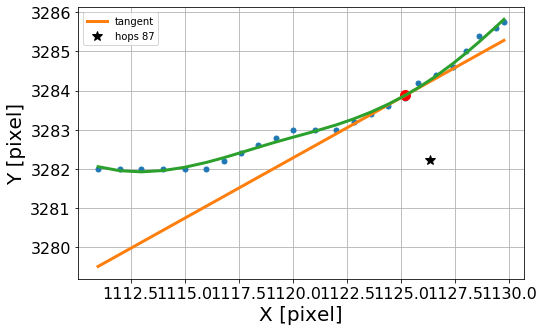

<SkyCoord (ICRS): (ra, dec) in deg
    (83.8435, -5.0206)> (array(1134.04641179), array(3289.42809366))
Smoothing parameter s: 0.5655751692301286
X-coordinate of closest position: 1129.7499999999889
Slope of tangent: 0.49628952177452995
Position Angle of Tangent: 116.39472308478402 E of N


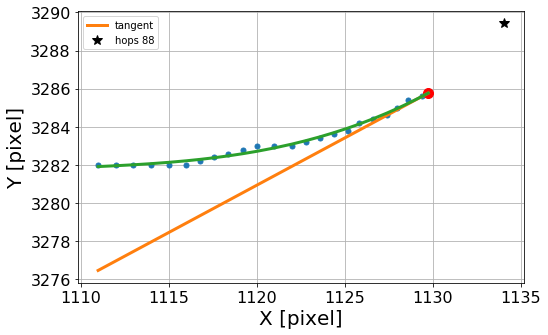

<SkyCoord (ICRS): (ra, dec) in deg
    (83.8263, -5.0092)> (array(1164.8891174), array(3309.94396076))
Smoothing parameter s: 0.48183023934883296
X-coordinate of closest position: 1161.9999999999964
Slope of tangent: 0.8973132249076738
Position Angle of Tangent: 131.90204857615407 E of N


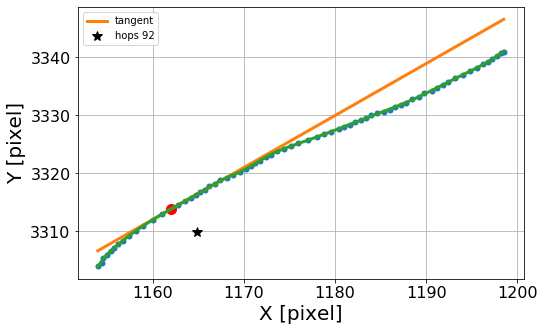

<SkyCoord (ICRS): (ra, dec) in deg
    (83.8738, -4.9802)> (array(1079.71571042), array(3362.14226475))
Smoothing parameter s: 0.1721598534233082
X-coordinate of closest position: 1077.9999999999966
Slope of tangent: -3.8959231655411264
Position Angle of Tangent: 14.395818696063841 E of N


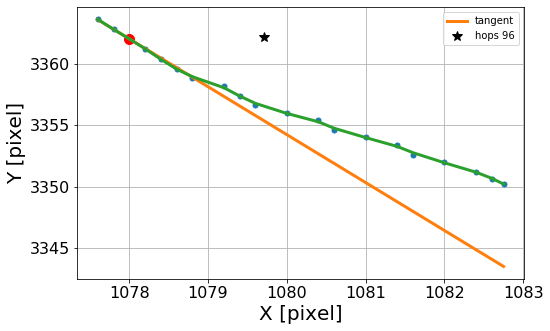

<SkyCoord (ICRS): (ra, dec) in deg
    (83.6229, -4.9252)> (array(1529.66675506), array(3461.03102014))
Error on input data
Filament 235_north has non-unique x values, flipping the x and y coordinates to use spline interpolation.
Smoothing parameter s: 0.08523759159553129
X-coordinate of closest position: 3460.499999999992
Slope of tangent: 7277.28598718925
Position Angle of Tangent: 179.99212676549288 E of N


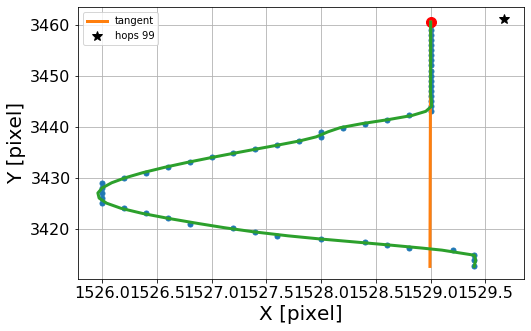

<SkyCoord (ICRS): (ra, dec) in deg
    (84.4857, -6.9442)> (array(-13.60625978), array(-173.46315566))
Error on input data
Filament 262_south has non-unique x values, flipping the x and y coordinates to use spline interpolation.
Smoothing parameter s: 38.18832800633874
X-coordinate of closest position: 51.1999999999864
Slope of tangent: -3.514842439540694
Position Angle of Tangent: 15.881464756701604 E of N


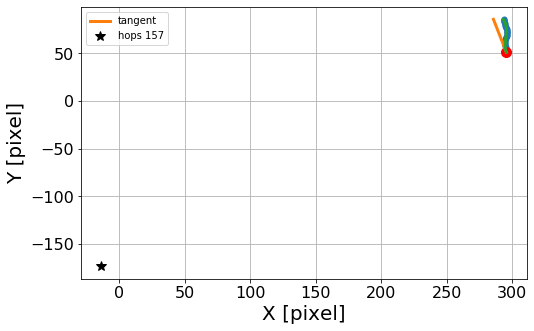

<SkyCoord (ICRS): (ra, dec) in deg
    (84.3519, -6.9758)> (array(225.51363212), array(-230.10156587))
Error on input data
Filament 262_south has non-unique x values, flipping the x and y coordinates to use spline interpolation.
Smoothing parameter s: 28.98046942801247
X-coordinate of closest position: 51.1999999999864
Slope of tangent: -3.514842439540694
Position Angle of Tangent: 15.881464756701604 E of N


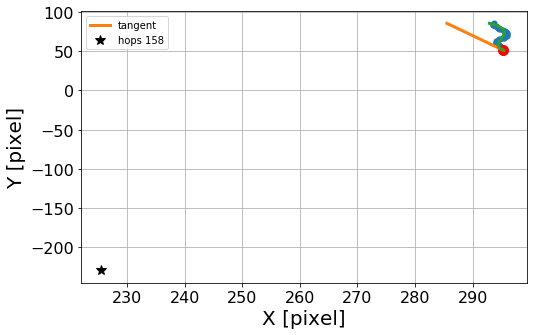

<SkyCoord (ICRS): (ra, dec) in deg
    (84.4627, -6.789)> (array(27.14472274), array(105.89293627))
Smoothing parameter s: 10.618937149587564
X-coordinate of closest position: 66.80000000000655
Slope of tangent: 1.3846040851206414
Position Angle of Tangent: 144.1621251117571 E of N


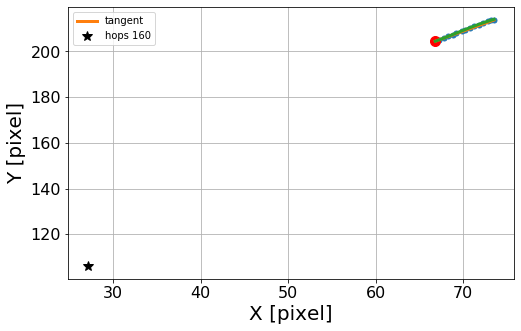

<SkyCoord (ICRS): (ra, dec) in deg
    (84.1047, -6.7449)> (array(666.97129145), array(185.72515576))
Error on input data
Filament 191_south has non-unique x values, flipping the x and y coordinates to use spline interpolation.
Flipping x and y still didn't help! Unflipping and only interpolating 20 points on either            side of the minimum distance point.
This also didn't work! Last resort: sorting by x-value.
Smoothing parameter s: 0.9052887225826158
X-coordinate of closest position: 659.8
Slope of tangent: -1.2000640228719872
Position Angle of Tangent: 39.804067762404806 E of N


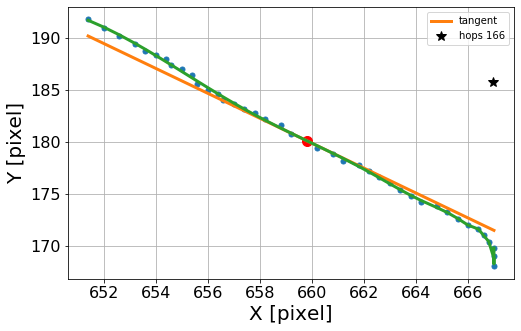

<SkyCoord (ICRS): (ra, dec) in deg
    (84.0789, -6.7563)> (array(713.09816027), array(165.22564749))
Smoothing parameter s: 0.024607362539133388
X-coordinate of closest position: 712.9999999999966
Slope of tangent: 0.007916857775648035
Position Angle of Tangent: 90.4535930611458 E of N


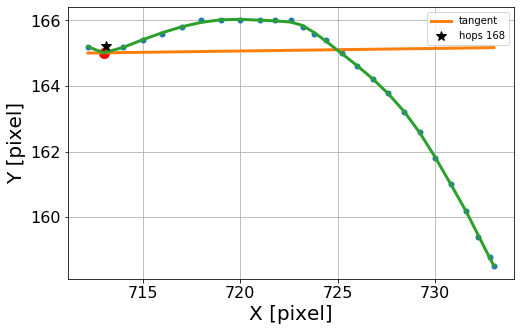

<SkyCoord (ICRS): (ra, dec) in deg
    (84.1505, -6.6477)> (array(585.00427922), array(360.62764004))
Smoothing parameter s: 0.09871479048319363
X-coordinate of closest position: 584.1999999999821
Slope of tangent: 1.4752350716139178
Position Angle of Tangent: 145.86830070647704 E of N


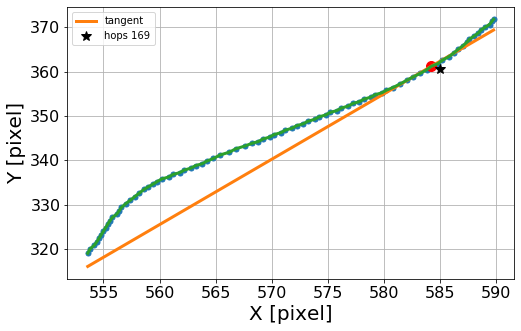

<SkyCoord (ICRS): (ra, dec) in deg
    (84.1077, -6.4163)> (array(661.33243402), array(777.14899831))
Error on input data
Filament 17_south has non-unique x values, flipping the x and y coordinates to use spline interpolation.
Flipping x and y still didn't help! Unflipping and only interpolating 20 points on either            side of the minimum distance point.
Smoothing parameter s: 0.09136280773437244
X-coordinate of closest position: 660.9999999999909
Slope of tangent: 0.14763837216646042
Position Angle of Tangent: 98.39838618548951 E of N


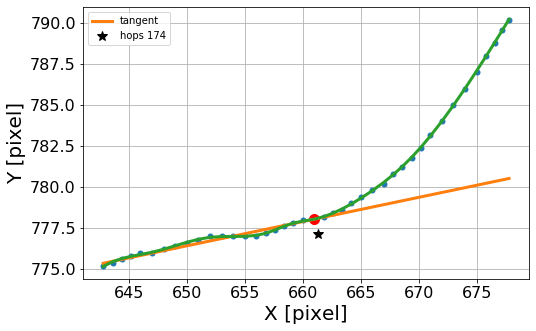

<SkyCoord (ICRS): (ra, dec) in deg
    (83.9584, -6.5815)> (array(928.43745654), array(479.88542343))
Error on input data
Filament 128_south has non-unique x values, flipping the x and y coordinates to use spline interpolation.
Flipping x and y still didn't help! Unflipping and only interpolating 20 points on either            side of the minimum distance point.
This also didn't work! Last resort: sorting by x-value.
Smoothing parameter s: 2.35500301545406
X-coordinate of closest position: 911.9999999999916
Slope of tangent: nan
Position Angle of Tangent: nan E of N


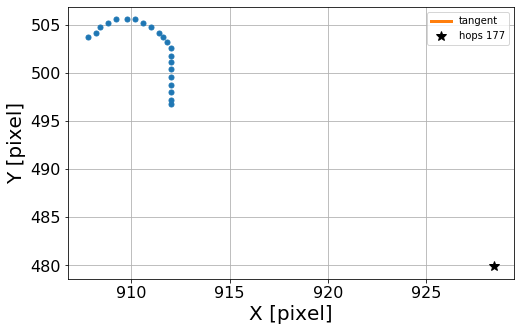

<SkyCoord (ICRS): (ra, dec) in deg
    (84.1025, -6.3781)> (array(670.60319792), array(845.90921214))
Error on input data
Filament 19_south has non-unique x values, flipping the x and y coordinates to use spline interpolation.
Smoothing parameter s: 1.034038021164739
X-coordinate of closest position: 841.4999999999704
Slope of tangent: -55.595728562026075
Position Angle of Tangent: 1.0304676850065277 E of N


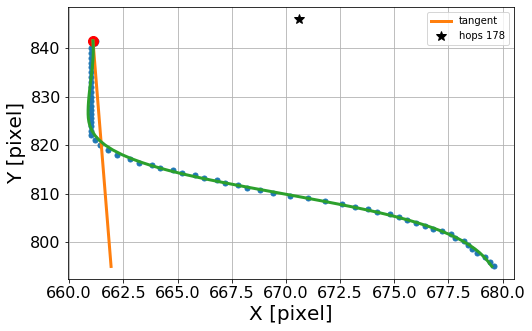

<SkyCoord (ICRS): (ra, dec) in deg
    (84.091, -6.3916)> (array(691.18514482), array(821.61851929))
Error on input data
Filament 19_south has non-unique x values, flipping the x and y coordinates to use spline interpolation.
Smoothing parameter s: 2.2774953862399294
X-coordinate of closest position: 805.7999999999961
Slope of tangent: -1.0329534879760083
Position Angle of Tangent: 44.07133613690534 E of N


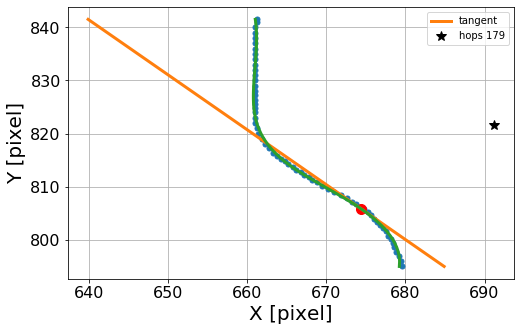

<SkyCoord (ICRS): (ra, dec) in deg
    (84.0813, -6.3701)> (array(708.52095003), array(860.32311672))
Error on input data
Filament 19_south has non-unique x values, flipping the x and y coordinates to use spline interpolation.
Smoothing parameter s: 5.088076689578056
X-coordinate of closest position: 841.4999999999704
Slope of tangent: -6.860170458718906
Position Angle of Tangent: 8.293534133626139 E of N


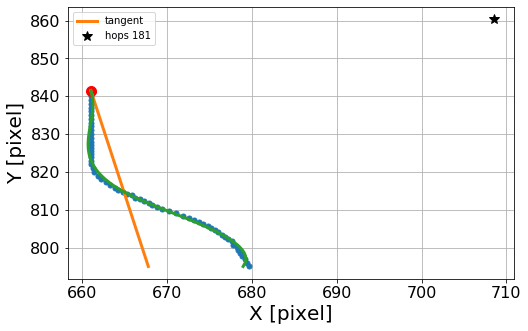

<SkyCoord (ICRS): (ra, dec) in deg
    (84.0785, -6.3695)> (array(713.52937306), array(861.40488724))
Error on input data
Filament 19_south has non-unique x values, flipping the x and y coordinates to use spline interpolation.
Smoothing parameter s: 5.594048072622906
X-coordinate of closest position: 841.4999999999704
Slope of tangent: -7.661073241318719
Position Angle of Tangent: 7.4367730038778745 E of N


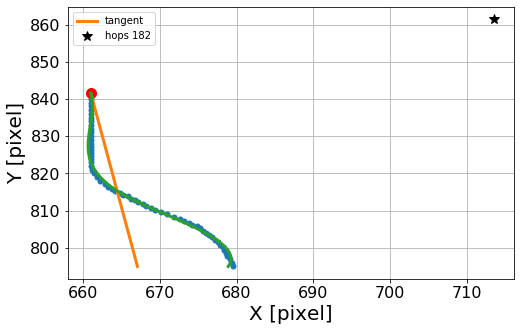

<SkyCoord (ICRS): (ra, dec) in deg
    (84.1352, -6.0212)> (array(611.79198268), array(1488.28815375))
Error on input data
Filament 88_south has non-unique x values, flipping the x and y coordinates to use spline interpolation.
Smoothing parameter s: 1.1315991674835757
X-coordinate of closest position: 1481.9999999999993
Slope of tangent: 1.564550140052206
Position Angle of Tangent: 147.41485784948702 E of N


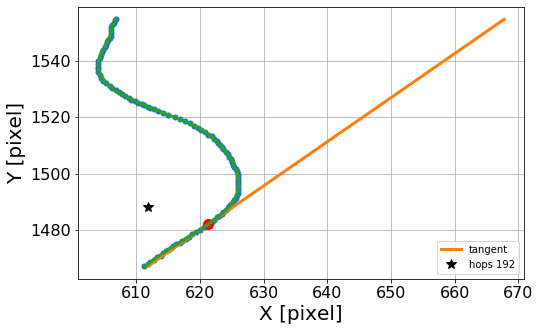

<SkyCoord (ICRS): (ra, dec) in deg
    (83.8424, -6.2184)> (array(1135.90176101), array(1133.43963788))
Smoothing parameter s: 2.917289566683485
X-coordinate of closest position: 1160.4000000000083
Slope of tangent: 0.39971455493628527
Position Angle of Tangent: 111.78730913544341 E of N


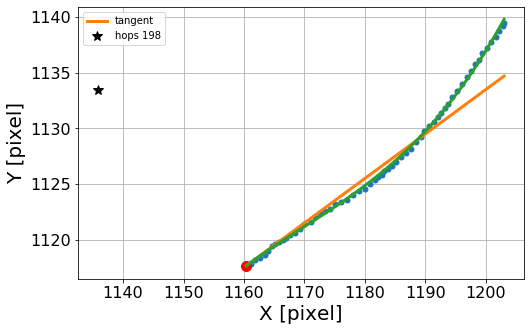

<SkyCoord (ICRS): (ra, dec) in deg
    (84.0952, -6.7684)> (array(683.97200679), array(143.43767498))
Smoothing parameter s: 0.27202192610930565
X-coordinate of closest position: 681.7999999999947
Slope of tangent: -1.0328466852927232
Position Angle of Tangent: 44.07429679999697 E of N


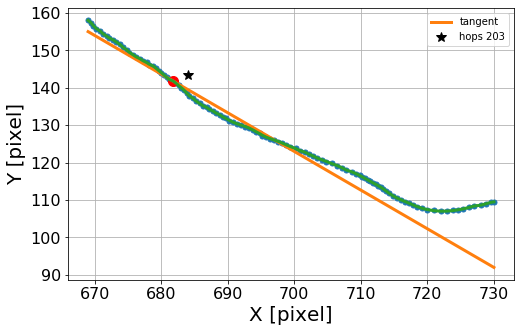

<SkyCoord (ICRS): (ra, dec) in deg
    (84.3212, -6.8304)> (array(280.11736133), array(31.6157297))
Error on input data
Filament 262_south has non-unique x values, flipping the x and y coordinates to use spline interpolation.
Smoothing parameter s: 2.4719013579115425
X-coordinate of closest position: 51.1999999999864
Slope of tangent: -7.183987164407036
Position Angle of Tangent: 7.924563802203011 E of N


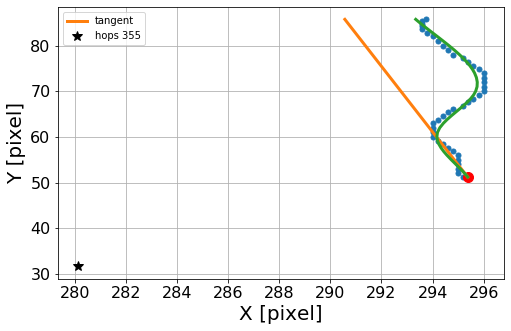

<SkyCoord (ICRS): (ra, dec) in deg
    (83.853, -5.1751)> (array(1117.00289396), array(3011.35063715))
Smoothing parameter s: 0.8371957740450796
X-coordinate of closest position: 1117.59999999999
Slope of tangent: 0.023338567462246468
Position Angle of Tangent: 91.33695870860217 E of N


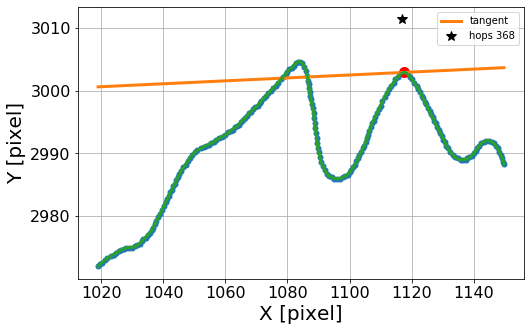

<SkyCoord (ICRS): (ra, dec) in deg
    (83.8651, -5.1593)> (array(1095.31208279), array(3039.78940866))
Smoothing parameter s: 1.0838879210957888
X-coordinate of closest position: 1093.0000000000114
Slope of tangent: -0.31334783232481933
Position Angle of Tangent: 72.60173065437591 E of N


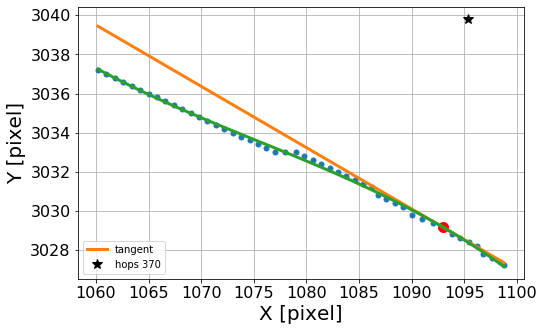

<SkyCoord (ICRS): (ra, dec) in deg
    (83.8742, -4.9975)> (array(1078.99843036), array(3331.00548837))
Error on input data
Filament 267_north has non-unique x values, flipping the x and y coordinates to use spline interpolation.
Smoothing parameter s: 0.47221645675086343
X-coordinate of closest position: 3328.2000000000057
Slope of tangent: -1.3850888898261389
Position Angle of Tangent: 35.82835495343612 E of N


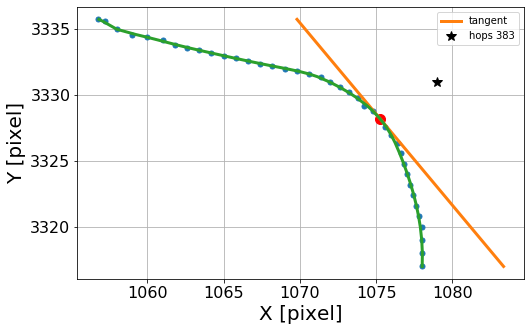

In [761]:
from scipy import interpolate
import matplotlib.pyplot as plt
import numpy as np
l_fil_pa = []


t_out = ascii.read("physics_outflows.txt")
t_fil = ascii.read("closest_filament.txt")
wcs = WCS(c18_full.header)

s_fac_dist = 0.1 #sprep smoothing factor as a fraction of the distance to source..

npix = 0 #Number of pixels on either side of the closest point to use for spline interpolation.

sortx = False #Sort the filament x-values from lowest to highest? splrep might need this.

for row_fil in t_fil:
    source = row_fil["source"]
    
    out_row = t_out[t_out["Source"] == source][0]
    source_coord = SkyCoord(out_row["RAJ2000"], out_row["DEJ2000"], unit=u.deg)
    source_xy = source_coord.to_pixel(wcs)
    print(source_coord, source_xy)
    

    closest_fil = row_fil["filament"]
    fil_file =  "../filaments/filaments_fullmap/filament{}.txt".format(closest_fil)
    fil_coords = np.loadtxt(fil_file)
    x, y = fil_coords[:,0], fil_coords[:,1]
    
    if sortx:
        i_sort = np.argsort(x)
        x = x[i_sort]
        y = y[i_sort]
    
    dist = ((source_xy[0] - x)**2. + (source_xy[1] - y)**2.)**0.5
    min_dist = min(dist)
    i_closestpix = np.argmin(dist)
    
    if source == "hops 75":
        i_closestpix -= 1
        
    try:
        tck = interpolate.splrep(x,y,s=s_fac_dist*min_dist)
        flipped=False
    except ValueError as ve:
        print(ve)
        print("Filament {} has non-unique x values, flipping the x and y coordinates to use spline interpolation.".format(
        closest_fil))
        try:
            x,y = y,x
    #         plt.plot(y,x)
            tck = interpolate.splrep(x,y,s=s_fac_dist*min_dist)
            flipped = True
        
        except ValueError as ve:
            npix=20
            print("Flipping x and y still didn't help! Unflipping and only interpolating {} points on either\
            side of the minimum distance point.".format(npix))
            try:
                x,y = y,x
                flipped = False
                x = x[i_closestpix - npix : i_closestpix + npix+1]
                y = y[i_closestpix - npix : i_closestpix + npix+1]
                i_closestpix = len(x) // 2
                tck = interpolate.splrep(x,y,s=s_fac_dist*min_dist)
            except ValueError as ve:
                print("This also didn't work! Last resort: sorting by x-value.")
    #             x, y, dist = x[::3], y[::3], dist[::3]
    #             i_closestpix = np.argmin(dist)
                i_sort = np.argsort(x)
                x = x[i_sort]
                y = y[i_sort]
                dist = ((source_xy[0] - x)**2. + (source_xy[1] - y)**2.)**0.5
                i_closestpix = np.argmin(dist)
                tck = interpolate.splrep(x,y,s=s_fac_dist*min_dist)
            
    print("Smoothing parameter s:", s_fac_dist*min_dist)
    # tck_s15 = interpolate.splrep(x,y,s=15)
    # print(tck)

    x0=x[i_closestpix]
    print("X-coordinate of closest position:", x0)
    y0 = interpolate.splev(x0,tck)
    dydx = interpolate.splev(x0,tck,der=1)


    if flipped:
        slope = 1/dydx
    else:
        slope = dydx
    print("Slope of tangent:", slope)
    print("Position Angle of Tangent:", np.arctan(slope)*180/(np.pi) + 90, "E of N")

    tngnt = lambda x: dydx*x + (y0-dydx*x0)

    fig, ax = plt.subplots(1, figsize=(8,5))

    if flipped:
        ax.plot(y,x, '.')
        ax.plot(y0, x0, "or")
        ax.plot(tngnt(x),x, label="tangent")
        ax.plot(interpolate.splev(x,tck), x)
#         ax.set_xlim(min(y)-5, max(y)+5)
#         ax.set_ylim(min(x)-5, max(x)+5)
    else:
        ax.plot(x,y, '.')
        ax.plot(x0, y0, "or")
        ax.plot(x,tngnt(x), label="tangent")
        ax.plot(x, interpolate.splev(x,tck))
#         ax.set_ylim(min(y)-5, max(y)+5)
#         ax.set_xlim(min(x)-5, max(x)+5)

    # ax.plot(x,y, '.')
    # ax.plot(x0, y0, "or")
    # ax.plot(x,tngnt(x), label="tangent")
    # ax.plot(x, interpolate.splev(x,tck))

    ax.set_xlabel("X [pixel]")
    ax.set_ylabel("Y [pixel]")
#     ax.set_ylim(3135,3145)
#     ax.set_xlim(1095,1110)
    ax.plot(source_xy[0], source_xy[1], "k*", label=source)

    ax.legend()

    # plt.xlim(550,600)
    # plt.ylim(320, 370)
#     start, end = ax.get_xlim()
    # ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
    # ax.xaxis.set_ticks(np.arange(start, end, 1))
    ax.grid(which='both')
#     ax.axis('equal')


    plt.show()
    # interpolate.splrep?

In [550]:
np.arctan(-)*180/(np.pi) + 90

0.0005729577951143483